# drive 마운트, seed 고정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.cluster import MiniBatchKMeans


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 데이터 로드 및 전처리

In [4]:
train_data  = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')

# 열 이름 변경
train_data.columns = train_data.columns.str.replace('fog_train.', '')
test_data.columns = test_data.columns.str.replace('fog_test.', '')

# 'Unnamed: 0' 열 제거
train_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

# 테스트 데이터에서 class 열 제거, 목표변수가 test데이터 열에 포함되면 안되기 때문
test_data = test_data.drop(columns=['class'], errors='ignore')

# 결측값 처리 (-99, -99.9를 NaN으로 대체)
train_data.replace([-99, -99.9], np.nan, inplace=True)
test_data.replace([-99, -99.9], np.nan, inplace=True)

In [5]:
# hm 컬럼에서 값이 0인 경우를 1로 대체
train_data['hm'] = train_data['hm'].replace(0, 1)

In [6]:
test_data

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7
3,L,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6
4,L,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262795,L,12,31,23,10,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9
262796,L,12,31,23,20,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9
262797,L,12,31,23,30,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8
262798,L,12,31,23,40,ED,322.0,3.7,4.3,0.0,72.5,0.0,1.4


# 본문

In [7]:
# 년도 변경 함수
def change_year(row):
    if len(row['year']) == 1 and row['year'].isalpha():  # 'year' 값이 알파벳 한 자리인지 확인
        if row['month'] == 2 and row['day'] == 29:
            return 2023 + (ord(row['year']) - ord('A')) % 4 * 4  # 윤년으로 대체
        else:
            return 2022 + (ord(row['year']) - ord('A')) % 4 * 4  # 평년으로 대체
    else:
        return None  # 알파벳 한 자리가 아닌 경우 None 반환

# 년도 변경
test_data['year'] = test_data.apply(change_year, axis=1)

# 결측치 개수 확인
missing_values_count = test_data['year'].isnull().sum()

# 결과 출력
print(f"변경된 'year' 열의 결측치 개수: {missing_values_count}")
print(test_data)

변경된 'year' 열의 결측치 개수: 0
        year  month  day  time  minute stn_id  ws10_deg  ws10_ms   ta   re  \
0       2034      1    1     0       0     AI     329.5      0.6 -2.5  0.0   
1       2034      1    1     0      10     AI     321.8      1.2 -2.5  0.0   
2       2034      1    1     0      20     AI       0.4      0.4 -2.5  0.0   
3       2034      1    1     0      30     AI     323.6      0.7 -2.6  0.0   
4       2034      1    1     0      40     AI     208.4      0.2 -2.6  0.0   
...      ...    ...  ...   ...     ...    ...       ...      ...  ...  ...   
262795  2034     12   31    23      10     ED     338.8      6.1  4.5  0.0   
262796  2034     12   31    23      20     ED     335.2      5.8  4.6  0.0   
262797  2034     12   31    23      30     ED     337.1      5.3  4.5  0.0   
262798  2034     12   31    23      40     ED     322.0      3.7  4.3  0.0   
262799  2034     12   31    23      50     ED      33.6      2.8  4.3  0.0   

          hm  sun10   ts  
0       87.5

In [8]:
train_data['year'] = train_data['year'].replace({'I': 2020, 'J': 2021, 'K': 2022})


In [9]:
# 'time' 열을 'hour' 열로 변경
train_data.rename(columns={'time': 'hour'}, inplace=True)
test_data.rename(columns={'time': 'hour'}, inplace=True)

In [10]:
# 'datetime' 열 추가
train_data['datetime'] = pd.to_datetime(train_data[['year', 'month', 'day', 'hour', 'minute']])

In [11]:
# 'datetime' 열 추가
test_data['datetime'] = pd.to_datetime(test_data[['year', 'month', 'day', 'hour', 'minute']])

# 본문

In [12]:
def fill_class(row):
    if pd.isna(row['class']):
        if row['vis1'] < 200:
            return 1
        elif 200 <= row['vis1'] < 500:
            return 2
        elif 500 <= row['vis1'] < 1000:
            return 3
        else:
            return 4
    else:
        return row['class']

def interpolate_and_fill(df):
    # vis1 결측치 보간
    df['vis1'] = df['vis1'].interpolate(method='time')

    # 양 끝의 결측치를 다음 값과 이전 값으로 채우기
    df['vis1'] = df['vis1'].ffill().bfill()

    # vis1 값을 바탕으로 class 결측값 대체
    df['class'] = df.apply(fill_class, axis=1)

    # vis1, class 열을 제외한 나머지 수치형 변수들에 대해 결측치 보간
    numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(['vis1', 'class'])
    df[numerical_cols] = df[numerical_cols].interpolate(method='time')

    # 양 끝의 결측치를 다음 값과 이전 값으로 채우기
    df[numerical_cols] = df[numerical_cols].ffill().bfill()

    return df

In [13]:
def interpolate_and_fill_test(df):
# vis1, class 열을 제외한 나머지 수치형 변수들에 대해 결측치 보간
    numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(['vis1', 'class'])
    df[numerical_cols] = df[numerical_cols].interpolate(method='time')

    # 양 끝의 결측치를 다음 값과 이전 값으로 채우기
    df[numerical_cols] = df[numerical_cols].ffill().bfill()

    return df

In [14]:
# test 데이터의 결측치를 보간
grouped_1 = test_data.groupby('stn_id')
interpolated_data_1 = []

for name, group in grouped_1:
    print(f"Processing region (interpolation): {name}")

    group = group.set_index('datetime')
    group = group.interpolate()  # 결측치 보간
    interpolated_data_1.append(group.reset_index())

# 보간된 데이터프레임을 다시 하나의 데이터프레임으로 합침
interpolated_test_data = pd.concat(interpolated_data_1)
interpolated_test_data

Processing region (interpolation): AI
Processing region (interpolation): BE
Processing region (interpolation): CC
Processing region (interpolation): DD
Processing region (interpolation): ED


,datetime,year,month,day,hour,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts
0,2034-01-01 00:00:00,2034,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6
1,2034-01-01 00:10:00,2034,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6
2,2034-01-01 00:20:00,2034,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7
3,2034-01-01 00:30:00,2034,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6
4,2034-01-01 00:40:00,2034,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2034-12-31 23:10:00,2034,12,31,23,10,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9
52556,2034-12-31 23:20:00,2034,12,31,23,20,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9
52557,2034-12-31 23:30:00,2034,12,31,23,30,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8
52558,2034-12-31 23:40:00,2034,12,31,23,40,ED,322.0,3.7,4.3,0.0,72.5,0.0,1.4


In [15]:
# 1. train결측치 보간
grouped = train_data.groupby('stn_id')
interpolated_data = []

for name, group in grouped:
    print(f"Processing region (interpolation): {name}")

    group = group.set_index('datetime')
    group = interpolate_and_fill(group)
    interpolated_data.append(group.reset_index())

# 보간된 데이터프레임을 다시 하나의 데이터프레임으로 합침
interpolated_train_data = pd.concat(interpolated_data)

Processing region (interpolation): AA
Processing region (interpolation): AB
Processing region (interpolation): AC
Processing region (interpolation): AD
Processing region (interpolation): AE
Processing region (interpolation): AF
Processing region (interpolation): AG
Processing region (interpolation): AH
Processing region (interpolation): BA
Processing region (interpolation): BB
Processing region (interpolation): BC
Processing region (interpolation): BD
Processing region (interpolation): CA
Processing region (interpolation): CB
Processing region (interpolation): DA
Processing region (interpolation): DB
Processing region (interpolation): DC
Processing region (interpolation): EA
Processing region (interpolation): EB
Processing region (interpolation): EC


# 삼각

In [16]:
# 풍향을 주기적인 특성으로 변환하는 함수
def transform_wind_direction(df):
    df['ws10_deg_sin'] = np.sin(np.deg2rad(df['ws10_deg']))
    df['ws10_deg_cos'] = np.cos(np.deg2rad(df['ws10_deg']))
    return df

# 데이터프레임에 변환 적용
interpolated_train_data = transform_wind_direction(interpolated_train_data)

# 결과 출력
print(interpolated_train_data[['ws10_deg', 'ws10_deg_sin', 'ws10_deg_cos']])


# 풍향을 주기적인 특성으로 변환하는 함수
def transform_wind_direction(df):
    df['ws10_deg_sin'] = np.sin(np.deg2rad(df['ws10_deg']))
    df['ws10_deg_cos'] = np.cos(np.deg2rad(df['ws10_deg']))
    return df

# 데이터프레임에 변환 적용
interpolated_test_data = transform_wind_direction(interpolated_test_data)

# 결과 출력
print(interpolated_test_data[['ws10_deg', 'ws10_deg_sin', 'ws10_deg_cos']])




        ws10_deg  ws10_deg_sin  ws10_deg_cos
0            0.0      0.000000      1.000000
1            0.0      0.000000      1.000000
2            0.0      0.000000      1.000000
3           27.8      0.466387      0.884581
4           59.7      0.863396      0.504528
...          ...           ...           ...
157817     305.3     -0.816138      0.577858
157818     293.8     -0.914960      0.403545
157819     274.2     -0.997314      0.073238
157820     270.3     -0.999986      0.005236
157821     254.8     -0.965016     -0.262189

[3156459 rows x 3 columns]
       ws10_deg  ws10_deg_sin  ws10_deg_cos
0         329.5     -0.507538      0.861629
1         321.8     -0.618408      0.785857
2           0.4      0.006981      0.999976
3         323.6     -0.593419      0.804894
4         208.4     -0.475624     -0.879649
...         ...           ...           ...
52555     338.8     -0.361625      0.932324
52556     335.2     -0.419452      0.907777
52557     337.1     -0.389124      0

In [17]:
# 삼각함수를 사용한 시계열 특성 생성 함수
def create_sin_cos_features(df):
    # 시간 단위로 변환
    df['seconds_in_day'] = df['hour'] * 3600 + df['minute'] * 60
    df['seconds_in_year'] = (df['datetime'] - pd.to_datetime(df['datetime'].dt.year.astype(str) + '-01-01')).dt.total_seconds()

    # 하루를 기준으로 시간(hour, minute) 변환
    df['time_sin'] = np.sin(2 * np.pi * df['seconds_in_day'] / 86400)
    df['time_cos'] = np.cos(2 * np.pi * df['seconds_in_day'] / 86400)

    # 1년을 기준으로 시간(year, month, day) 변환
    df['yearly_time_sin'] = np.sin(2 * np.pi * df['seconds_in_year'] / (365 * 86400))
    df['yearly_time_cos'] = np.cos(2 * np.pi * df['seconds_in_year'] / (365 * 86400))

    return df


In [18]:

# 시계열 특성 생성
interpolated_train_data_t = create_sin_cos_features(interpolated_train_data)

print("\nFinal DataFrame with Sin and Cos Features:")
print(interpolated_train_data_t[['datetime', 'time_sin', 'time_cos', 'yearly_time_sin', 'yearly_time_cos']].head())


Final DataFrame with Sin and Cos Features:
             datetime  time_sin  time_cos  yearly_time_sin  yearly_time_cos
0 2020-01-01 00:10:00  0.043619  0.999048         0.000120              1.0
1 2020-01-01 00:20:00  0.087156  0.996195         0.000239              1.0
2 2020-01-01 00:30:00  0.130526  0.991445         0.000359              1.0
3 2020-01-01 00:40:00  0.173648  0.984808         0.000478              1.0
4 2020-01-01 00:50:00  0.216440  0.976296         0.000598              1.0


In [19]:

# 시계열 특성 생성
interpolated_test_data_t = create_sin_cos_features(interpolated_test_data)

print("\nFinal DataFrame with Sin and Cos Features:")
print(interpolated_test_data_t[['datetime', 'time_sin', 'time_cos', 'yearly_time_sin', 'yearly_time_cos']].head())


Final DataFrame with Sin and Cos Features:
             datetime  time_sin  time_cos  yearly_time_sin  yearly_time_cos
0 2034-01-01 00:00:00  0.000000  1.000000         0.000000              1.0
1 2034-01-01 00:10:00  0.043619  0.999048         0.000120              1.0
2 2034-01-01 00:20:00  0.087156  0.996195         0.000239              1.0
3 2034-01-01 00:30:00  0.130526  0.991445         0.000359              1.0
4 2034-01-01 00:40:00  0.173648  0.984808         0.000478              1.0


# 파생변수

In [20]:
interpolated_train_data_t['Temp_Diff'] = interpolated_train_data_t['ta'] - interpolated_train_data_t['ts']
interpolated_test_data_t['Temp_Diff'] = interpolated_test_data_t['ta'] - interpolated_test_data_t['ts']

In [21]:
#interpolated_train_data_t['Fog_Likelihood_Index'] = (interpolated_train_data_t['Temp_Diff'] * interpolated_train_data_t['hm']) / (interpolated_train_data_t['ws10_ms'] + 1)
#interpolated_test_data_t['Fog_Likelihood_Index'] = (interpolated_test_data_t['Temp_Diff'] * interpolated_test_data_t['hm']) / (interpolated_test_data_t['ws10_ms'] + 1)

In [22]:
import pandas as pd
import numpy as np

# 매그너스 공식의 상수
a = 17.62
b = 243.12

# 이슬점 계산 함수
def calculate_dew_point(temperature, humidity):
    gamma = (a * temperature) / (b + temperature) + np.log(humidity / 100.0)
    dew_point = (b * gamma) / (a - gamma)
    return dew_point


In [23]:
# 이슬점 온도 계산 및 컬럼 추가
interpolated_train_data_t['dew_point'] = interpolated_train_data_t.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [24]:
interpolated_test_data_t['dew_point'] = interpolated_test_data_t.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [25]:
interpolated_train_data_t['dew_point_minus_ta'] = -(interpolated_train_data_t['dew_point'] - interpolated_train_data_t['ta']).round(1)

In [26]:
interpolated_test_data_t['dew_point_minus_ta'] = -(interpolated_test_data_t['dew_point'] - interpolated_test_data_t['ta']).round(1)

In [27]:
interpolated_train_data_t['sqrt_rounded_diff'] = np.sqrt(interpolated_train_data_t['dew_point_minus_ta'])

In [28]:
interpolated_test_data_t['sqrt_rounded_diff'] = np.sqrt(interpolated_test_data_t['dew_point_minus_ta'])

# ㅄ

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# 상관계수 계산 함수
def calculate_correlations(df):
    results = []

    for region in df['stn_id'].unique():
        region_data = df[df['stn_id'] == region]

        # 피어슨 상관계수 계산
        pearson_corr, pearson_p_value = pearsonr(region_data['hm'], region_data['vis1'])

        # 스피어만 상관계수 계산
        spearman_corr, spearman_p_value = spearmanr(region_data['hm'], region_data['vis1'])

        results.append({
            'stn_id': region,
            'pearson_corr': pearson_corr,
            'pearson_p_value': pearson_p_value,
            'spearman_corr': spearman_corr,
            'spearman_p_value': spearman_p_value
        })

    return pd.DataFrame(results)

# 지역별 상관계수 계산
correlation_results = calculate_correlations(interpolated_train_data_t)

# 결과 출력
print(correlation_results)


   stn_id  pearson_corr  pearson_p_value  spearman_corr  spearman_p_value
0      AA     -0.456765              0.0      -0.433308               0.0
1      AB     -0.229227              0.0      -0.341473               0.0
2      AC     -0.386000              0.0      -0.342532               0.0
3      AD     -0.398568              0.0      -0.451928               0.0
4      AE     -0.518738              0.0      -0.522066               0.0
5      AF     -0.435854              0.0      -0.445527               0.0
6      AG     -0.429407              0.0      -0.455256               0.0
7      AH     -0.431774              0.0      -0.485340               0.0
8      BA     -0.533237              0.0      -0.555519               0.0
9      BB     -0.345915              0.0      -0.429837               0.0
10     BC     -0.421524              0.0      -0.436857               0.0
11     BD     -0.445284              0.0      -0.544725               0.0
12     CA     -0.276846              0

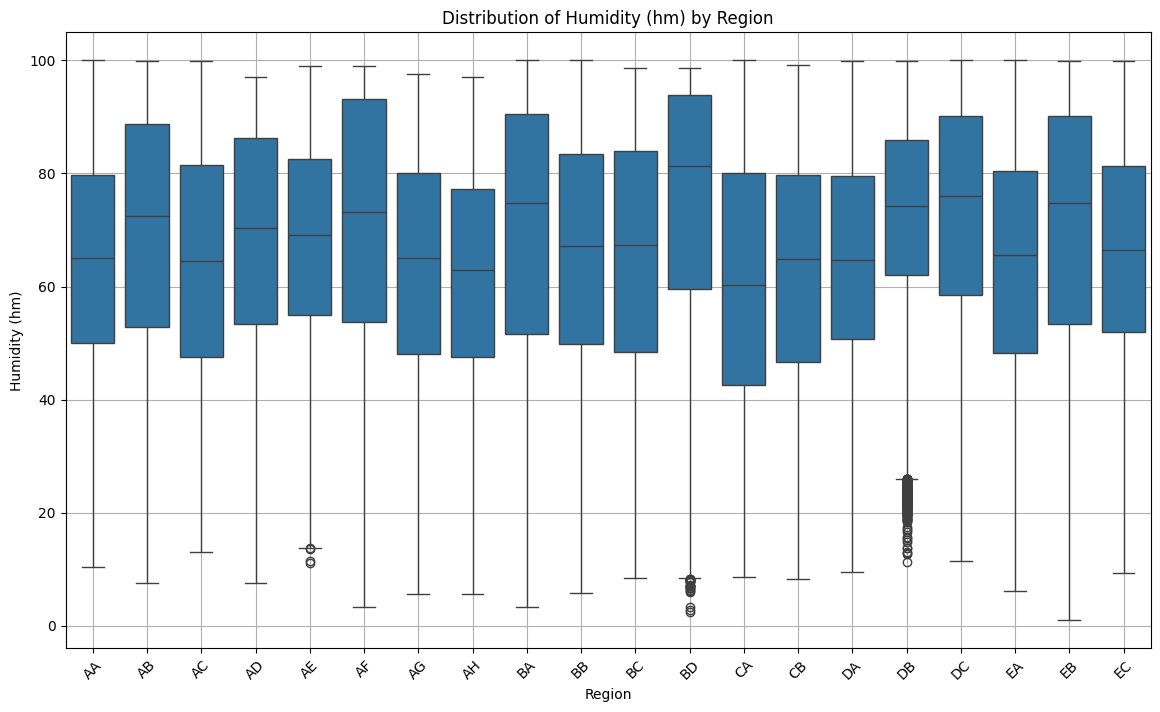

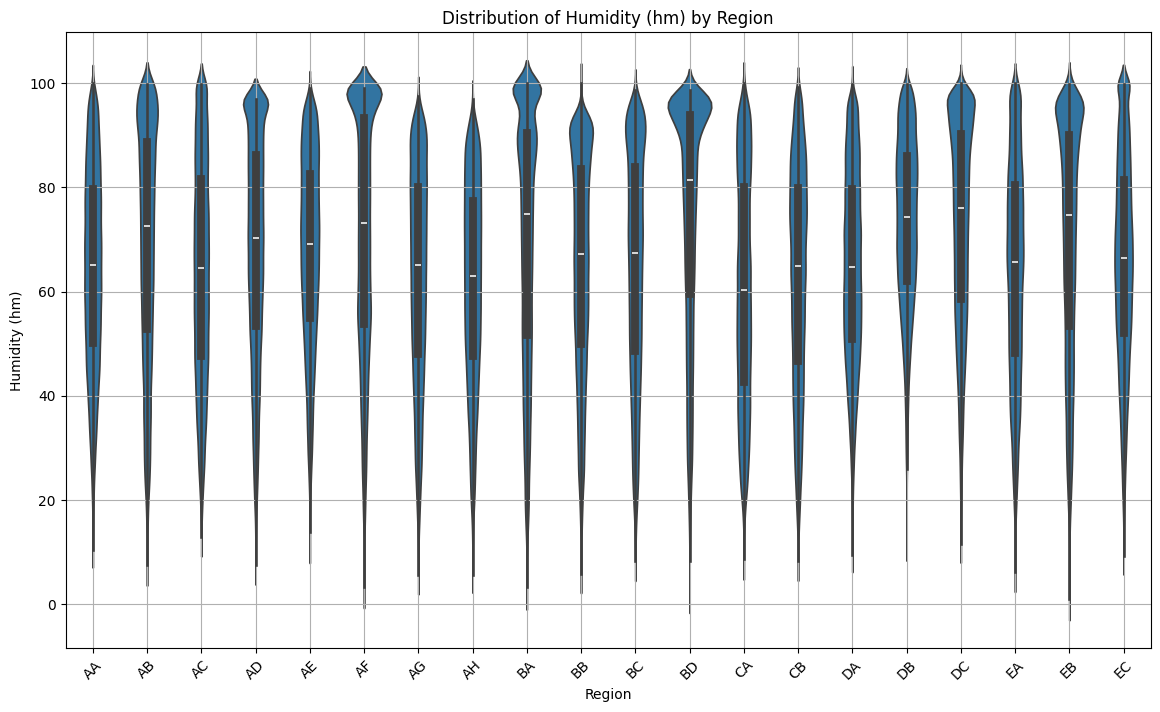

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
# interpolated_train_data_t = pd.read_csv('path_to_your_csv_file.csv')

# 상자 그림 그리기
plt.figure(figsize=(14, 8))
sns.boxplot(x='stn_id', y='hm', data=interpolated_train_data_t)
plt.title('Distribution of Humidity (hm) by Region')
plt.xlabel('Region')
plt.ylabel('Humidity (hm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 바이올린 플롯 그리기
plt.figure(figsize=(14, 8))
sns.violinplot(x='stn_id', y='hm', data=interpolated_train_data_t)
plt.title('Distribution of Humidity (hm) by Region')
plt.xlabel('Region')
plt.ylabel('Humidity (hm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


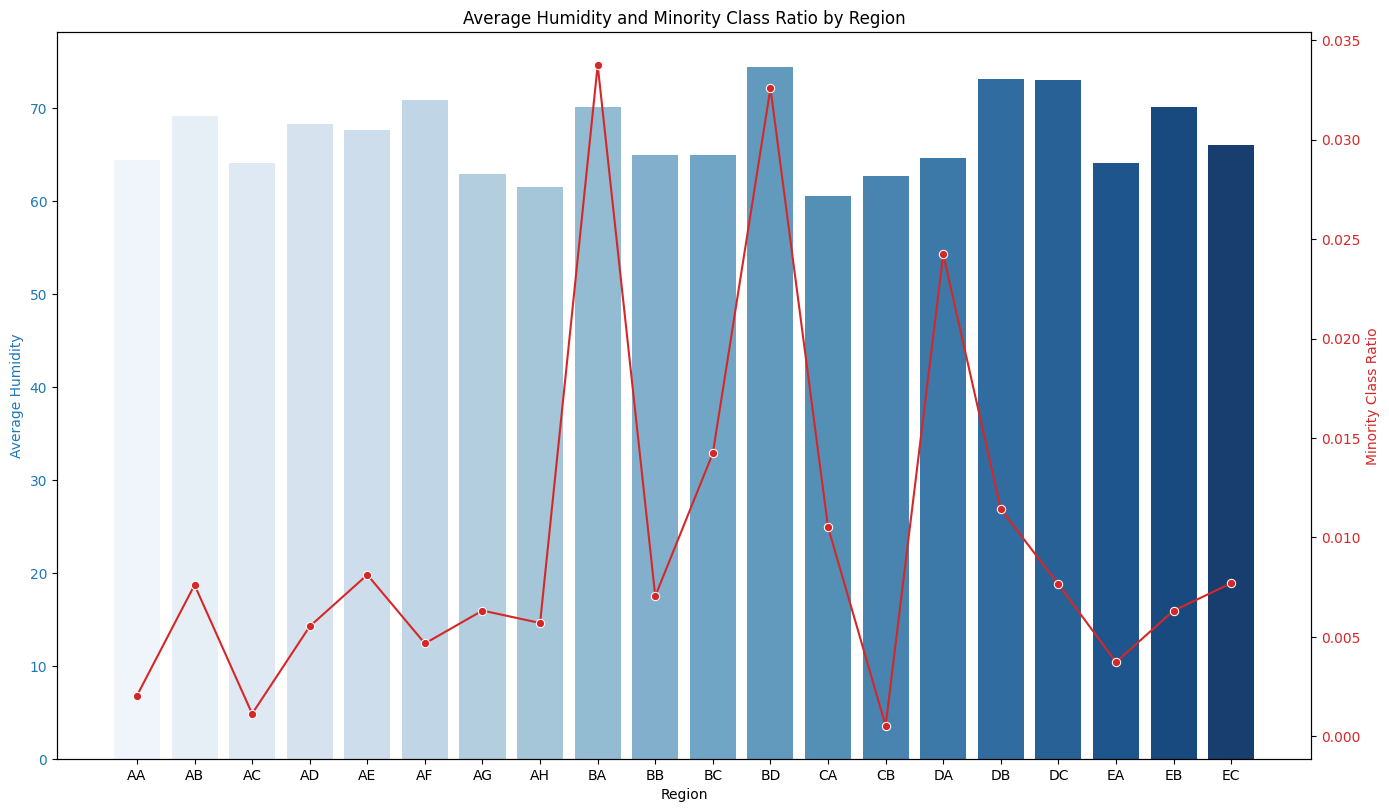

In [34]:
# 평균 습도와 소수 클래스 비율을 함께 시각화
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Region')
ax1.set_ylabel('Average Humidity', color=color)
sns.barplot(x='stn_id', y='avg_hm', data=region_stats, ax=ax1, palette='Blues')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Minority Class Ratio', color=color)
sns.lineplot(x='stn_id', y='minority_class_ratio', data=region_stats, marker='o', color=color, sort=False)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Average Humidity and Minority Class Ratio by Region')
plt.show()


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 지역별 평균 습도 계산
region_avg_hm = interpolated_train_data_t.groupby('stn_id')['hm'].mean().reset_index()
region_avg_hm.columns = ['stn_id', 'avg_hm']

# 소수 클래스 정의
minority_classes = [1, 2, 3]

# 지역별 소수 클래스 비율 계산
class_counts = interpolated_train_data_t.groupby(['stn_id', 'class']).size().unstack(fill_value=0)
class_counts['minority_class_sum'] = class_counts[minority_classes].sum(axis=1)
class_counts['total'] = class_counts.sum(axis=1)
class_counts['minority_class_ratio'] = class_counts['minority_class_sum'] / class_counts['total']
minority_class_ratio = class_counts['minority_class_ratio'].reset_index()

# 데이터 병합
region_stats = pd.merge(region_avg_hm, minority_class_ratio[['stn_id', 'minority_class_ratio']], on='stn_id')

# 결과 출력
print(region_stats)


   stn_id     avg_hm  minority_class_ratio
0      AA  64.398408              0.002042
1      AB  69.161282              0.007608
2      AC  64.087905              0.001133
3      AD  68.268837              0.005526
4      AE  67.637863              0.008120
5      AF  70.808352              0.004667
6      AG  62.936740              0.006321
7      AH  61.525017              0.005695
8      BA  70.063078              0.033753
9      BB  64.981920              0.007047
10     BC  64.923036              0.014235
11     BD  74.447417              0.032592
12     CA  60.484839              0.010514
13     CB  62.662608              0.000532
14     DA  64.656493              0.024230
15     DB  73.090395              0.011419
16     DC  72.965218              0.007640
17     EA  64.052690              0.003731
18     EB  70.155449              0.006315
19     EC  65.973359              0.007696


# 시계

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import xgboost as xgb

# 시계열 특성 생성 함수 정의
def create_time_series_features(df):
    # 이동 평균
    df['dew_point_minus_ta_mean_3h'] = df['dew_point_minus_ta'].rolling(window=18, min_periods=1).mean()  # 3시간 이동 평균 (10분 간격 데이터)
    df['dew_point_minus_ta_mean_5h'] = df['dew_point_minus_ta'].rolling(window=30, min_periods=1).mean()  # 5시간 이동 평균 (10분 간격 데이터)

    # 이동 표준편차
    df['dew_point_minus_ta_std_1h'] = df['dew_point_minus_ta'].rolling(window=6, min_periods=1).std()     # 1시간 이동 표준편차
    df['dew_point_minus_ta_std_3h'] = df['dew_point_minus_ta'].rolling(window=18, min_periods=1).std()    # 3시간 이동 표준편차
    df['dew_point_minus_ta_std_5h'] = df['dew_point_minus_ta'].rolling(window=30, min_periods=1).std()    # 5시간 이동 표준편차
    df['dew_point_minus_ta_std_9h'] = df['dew_point_minus_ta'].rolling(window=54, min_periods=1).std()   # 9시간 이동 표준편차
    df['dew_point_minus_ta_std_12h'] = df['dew_point_minus_ta'].rolling(window=72, min_periods=1).std()   # 12시간 이동 표준편차

    # ts 특성 생성
    df['ts_std1'] = df['ts'].rolling(window=6, min_periods=1).std()
    df['ts_std3'] = df['ts'].rolling(window=18, min_periods=1).std()
    df['ts_std5'] = df['ts'].rolling(window=30, min_periods=1).std()
    df['ts_std9'] = df['ts'].rolling(window=54, min_periods=1).std()
    df['ts_std12'] = df['ts'].rolling(window=72, min_periods=1).std()

    # ws10_ms 특성 생성
    df['ws10_ms_rolling_mean_1h'] = df['ws10_ms'].rolling(window=6, min_periods=1).mean()  # 1시간 이동 평균 (10분 간격 데이터)
    df['ws10_ms_rolling_mean_3h'] = df['ws10_ms'].rolling(window=18, min_periods=1).mean()  # 3시간 이동 평균 (10분 간격 데이터)
    df['ws10_ms_rolling_mean_5h'] = df['ws10_ms'].rolling(window=30, min_periods=1).mean()  # 5시간 이동 평균 (10분 간격 데이터)
    df['ws10_ms_rolling_mean_9h'] = df['ws10_ms'].rolling(window=54, min_periods=1).mean() # 9시간 이동 평균 (10분 간격 데이터)
    df['ws10_ms_rolling_mean_12h'] = df['ws10_ms'].rolling(window=72, min_periods=1).mean() # 12시간 이동 평균 (10분 간격 데이터)

    # 이동 표준편차 계산 및 변수명 변경
    df['ts_rolling_std_3h'] = df['ts'].rolling(window=18, min_periods=1).std()   # 3시간 이동 표준편차
    df['ts_rolling_std_5h'] = df['ts'].rolling(window=30, min_periods=1).std()   # 5시간 이동 표준편차
    df['ts_rolling_std_9h'] = df['ts'].rolling(window=54, min_periods=1).std()  # 9시간 이동 표준편차
    df['ts_rolling_std_12h'] = df['ts'].rolling(window=72, min_periods=1).std()  # 12시간 이동 표준편차

    # ta 특성 생성
    df['ta_rolling_mean_3h'] = df['ta'].rolling(window=18, min_periods=1).mean()  # 3시간 이동 평균 (10분 간격 데이터)

    df['ta_rolling_std_1h'] = df['ta'].rolling(window=6, min_periods=1).std()  # 1시간 이동 표준편차
    df['ta_rolling_std_3h'] = df['ta'].rolling(window=18, min_periods=1).std()  # 3시간 이동 표준편차
    df['ta_rolling_std_5h'] = df['ta'].rolling(window=30, min_periods=1).std()  # 5시간 이동 표준편차
    df['ta_rolling_std_9h'] = df['ta'].rolling(window=54, min_periods=1).std() # 9시간 이동 표준편차
    df['ta_rolling_std_12h'] = df['ta'].rolling(window=72, min_periods=1).std() # 12시간 이동 표준편차

    df['Temp_Diff_rolling_mean_1h'] = df['Temp_Diff'].rolling(window=6, min_periods=1).mean()  # 1시간 이동 평균

    # Temp_Diff 특성 생성
    df['Temp_Diff_rolling_std_1h'] = df['Temp_Diff'].rolling(window=6, min_periods=1).std()     # 1시간 이동 표준편차
    df['Temp_Diff_rolling_std_3h'] = df['Temp_Diff'].rolling(window=18, min_periods=1).std()    # 3시간 이동 표준편차
    df['Temp_Diff_rolling_std_5h'] = df['Temp_Diff'].rolling(window=30, min_periods=1).std()    # 5시간 이동 표준편차
    df['Temp_Diff_rolling_std_9h'] = df['Temp_Diff'].rolling(window=54, min_periods=1).std()   # 9시간 이동 표준편차
    df['Temp_Diff_rolling_std_12h'] = df['Temp_Diff'].rolling(window=72, min_periods=1).std()   # 12시간 이동 표준편차

    return df


In [30]:
# 데이터프레임 생성 (기존 데이터프레임을 사용하여 새로운 데이터프레임 생성)
train_data = interpolated_train_data_t.copy()
test_data = interpolated_test_data_t.copy()  # 테스트 데이터의 예시

# 지역별로 시계열 특성 생성 및 결측치 처리
train_data_list = []
test_data_list = []

for region in train_data['stn_id'].unique():
    # 훈련 데이터에 시계열 특성 생성
    train_region_data = train_data[train_data['stn_id'] == region].copy()
    train_region_data = create_time_series_features(train_region_data)
    train_region_data = train_region_data.dropna()  # 결측치 제거
    train_data_list.append(train_region_data)

for region in test_data['stn_id'].unique():
    # 테스트 데이터에 시계열 특성 생성
    test_region_data = test_data[test_data['stn_id'] == region].copy()
    test_region_data = create_time_series_features(test_region_data)
    test_region_data = test_region_data.fillna(method='bfill').fillna(method='ffill')  # 결측치 보간
    test_data_list.append(test_region_data)


In [31]:
# 리스트를 데이터프레임으로 결합
train_data_final = pd.concat(train_data_list)
test_data_final = pd.concat(test_data_list)

# 축약

In [32]:
import gc

# 필요 없는 데이터프레임 삭제
del interpolated_train_data_t
del train_data
del interpolated_train_data

# 가비지 컬렉터 실행
gc.collect()


38

In [33]:
# 필요 없는 열 제거 ## ws10_ms제거된상태
columns_to_drop = ['datetime', 'year', 'stn_id', 'month', 'day', 'hour', 'minute', 'seconds_in_day', 'seconds_in_year','dew_point_minus_ta', 'dew_point','ts','re', 'sqrt_rounded_diff', 'sun10','ws10_deg']

train_data_final_drop = train_data_final.drop(columns=columns_to_drop)
# 필요 없는 열 제거
test_data_final_drop = test_data_final.drop(columns=columns_to_drop)

In [39]:
train_data_final_drop

,ws10_ms,ta,hm,ws10_deg_sin,ws10_deg_cos,time_sin,time_cos,yearly_time_sin,yearly_time_cos,Temp_Diff,...,Temp_Diff_rolling_std_1h,Temp_Diff_rolling_std_3h,Temp_Diff_rolling_std_5h,Temp_Diff_rolling_std_9h,Temp_Diff_rolling_std_12h,stn_id_A,stn_id_B,stn_id_C,stn_id_D,stn_id_E
0,0.6,-2.5,87.5,-0.507538,0.861629,0.000000,1.000000,0.000000,1.0,-0.9,...,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0
1,1.2,-2.5,88.2,-0.618408,0.785857,0.043619,0.999048,0.000120,1.0,-0.9,...,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0
2,0.4,-2.5,88.6,0.006981,0.999976,0.087156,0.996195,0.000239,1.0,-0.8,...,0.057735,0.057735,0.057735,0.057735,0.057735,1,0,0,0,0
3,0.7,-2.6,88.7,-0.593419,0.804894,0.130526,0.991445,0.000359,1.0,-1.0,...,0.081650,0.081650,0.081650,0.081650,0.081650,1,0,0,0,0
4,0.2,-2.6,89.0,-0.475624,-0.879649,0.173648,0.984808,0.000478,1.0,-1.0,...,0.083666,0.083666,0.083666,0.083666,0.083666,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,6.1,4.5,71.3,-0.361625,0.932324,-0.216440,0.976296,-0.000598,1.0,2.6,...,0.104881,0.160473,0.201859,2.088628,2.578398,0,0,0,0,1
52556,5.8,4.6,71.4,-0.419452,0.907777,-0.173648,0.984808,-0.000478,1.0,2.7,...,0.075277,0.168034,0.187420,2.028701,2.511968,0,0,0,0,1
52557,5.3,4.5,72.1,-0.389124,0.921185,-0.130526,0.991445,-0.000359,1.0,2.7,...,0.063246,0.172354,0.184110,1.941568,2.414915,0,0,0,0,1
52558,3.7,4.3,72.5,-0.615661,0.788011,-0.087156,0.996195,-0.000239,1.0,2.9,...,0.098319,0.163799,0.173570,1.816156,2.302448,0,0,0,0,1


#XGBOOST

In [34]:
import pandas as pd
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

# 특징과 라벨 분리 (전체 훈련 데이터)
X_train_final = train_data_final_drop.drop(['class', 'vis1'], axis=1)
y_train_final = train_data_final_drop['class']

X_test = test_data_final_drop

# 클래스 라벨을 0부터 시작하도록 변환 (라벨 값이 1부터 시작하는 경우)
y_train_final = y_train_final - y_train_final.min()

# 라벨 값이 0부터 num_class-1 사이에 있는지 확인
assert y_train_final.min() >= 0 and y_train_final.max() < 4, "Train labels must be in the range [0, num_class)."

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_final), y=y_train_final)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train_final), class_weights)}

# 가중치 부여
weights = np.array([class_weights[label] for label in y_train_final])

# DMatrix 생성
dtrain = xgb.DMatrix(X_train_final, label=y_train_final, weight=weights)
dtest = xgb.DMatrix(X_test)

# XGBoost 모델 학습
param = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'eta': 0.3,
    'max_depth': 6,
    'seed': 42
}

num_round = 1100
evallist = [(dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# 테스트 데이터에 대한 예측
y_test_pred = bst.predict(dtest)

# 예측 결과를 1부터 시작하도록 변환
y_test_pred = y_test_pred + 1

# 예측 결과 출력
print("Test Data Predictions:")
print(y_test_pred)


[0]	train-mlogloss:1.24260
[1]	train-mlogloss:1.15322
[2]	train-mlogloss:1.08878
[3]	train-mlogloss:1.04142
[4]	train-mlogloss:1.00577
[5]	train-mlogloss:0.97644
[6]	train-mlogloss:0.95171
[7]	train-mlogloss:0.93074
[8]	train-mlogloss:0.91168
[9]	train-mlogloss:0.89576
[10]	train-mlogloss:0.88195
[11]	train-mlogloss:0.86825
[12]	train-mlogloss:0.85721
[13]	train-mlogloss:0.84735
[14]	train-mlogloss:0.83975
[15]	train-mlogloss:0.83186
[16]	train-mlogloss:0.82359
[17]	train-mlogloss:0.81815
[18]	train-mlogloss:0.81150
[19]	train-mlogloss:0.80450
[20]	train-mlogloss:0.79637
[21]	train-mlogloss:0.79136
[22]	train-mlogloss:0.78389
[23]	train-mlogloss:0.77748
[24]	train-mlogloss:0.77072
[25]	train-mlogloss:0.76254
[26]	train-mlogloss:0.75713
[27]	train-mlogloss:0.75114
[28]	train-mlogloss:0.74605
[29]	train-mlogloss:0.74222
[30]	train-mlogloss:0.73658
[31]	train-mlogloss:0.73259
[32]	train-mlogloss:0.72827
[33]	train-mlogloss:0.72416
[34]	train-mlogloss:0.72043
[35]	train-mlogloss:0.71643
[3

Feature Importance:
                       Feature  Importance
3                 ws10_deg_sin      8255.0
4                 ws10_deg_cos      7704.0
7              yearly_time_sin      7451.0
2                           hm      7165.0
29           ta_rolling_std_3h      6998.0
35    Temp_Diff_rolling_std_3h      6656.0
30           ta_rolling_std_5h      6601.0
32          ta_rolling_std_12h      6496.0
8              yearly_time_cos      6480.0
28           ta_rolling_std_1h      6349.0
38   Temp_Diff_rolling_std_12h      6328.0
36    Temp_Diff_rolling_std_5h      6299.0
16  dew_point_minus_ta_std_12h      6188.0
37    Temp_Diff_rolling_std_9h      6142.0
33   Temp_Diff_rolling_mean_1h      6116.0
26    ws10_ms_rolling_mean_12h      6110.0
34    Temp_Diff_rolling_std_1h      6011.0
18                     ts_std3      6000.0
31           ta_rolling_std_9h      5838.0
15   dew_point_minus_ta_std_9h      5792.0
1                           ta      5756.0
17                     ts_std1    

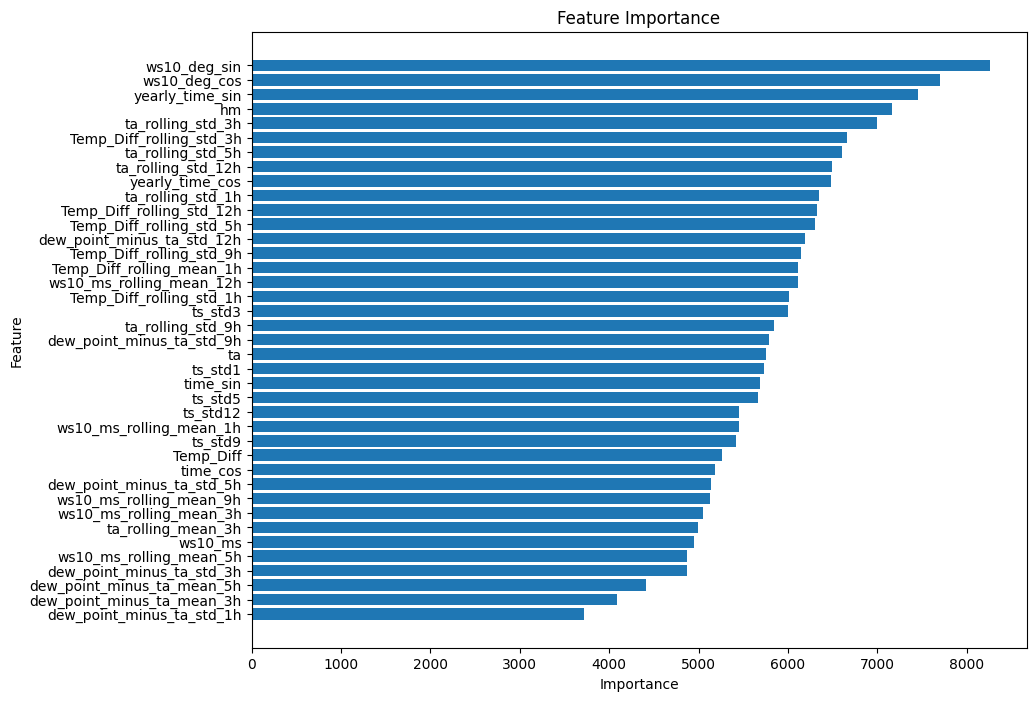

In [35]:
# Feature importance 구하기
importance = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# 중요도 내림차순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# feature importance 출력
print("Feature Importance:")
print(importance_df)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [37]:
# y_test_pred 값별 비율 계산
unique, counts = np.unique(y_test_pred, return_counts=True)
ratios = counts / counts.sum()

# 값과 비율 출력
for value, ratio in zip(unique, ratios):
    print(f"Value: {value}, Ratio: {ratio:.9f}")

Value: 1.0, Ratio: 0.001031202
Value: 2.0, Ratio: 0.006099696
Value: 3.0, Ratio: 0.005060883
Value: 4.0, Ratio: 0.987808219


In [39]:

# 예측 결과를 원래 클래스 라벨로 변환
y_test_pred = y_test_pred.astype(int) -1

# 제출하기 위해 test데이터 다시 불러옴
sub_test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')
sub_test_data = sub_test_data.drop(columns=['fog_test.class'], errors='ignore')

# 예측 결과를 데이터프레임으로 저장
sub_test_data['fog_test.class'] = y_test_pred

# 예측 결과 저장
sub_test_data.to_csv('240184.csv', index=False)
sub_test_data["fog_test.class"].value_counts()

fog_test.class
4    259596
2      1603
3      1330
1       271
Name: count, dtype: int64

In [40]:
# 파일 다운로드
from google.colab import files
files.download('240184.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
#이제그만